# CNN on Jewelry Products


## Contents
- [Problem Statement](#Problem-Statement)
- [Executive Summary](#Executive-Summary)
- [Data Source](#Data-Source)
- [Data Dictionary](#Data-Dictionary)
- [Data Import and Cleaning](#Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Retrieving images from links](#Retrieving-images-from-links)
- [OpenCv image preprocessing](#OpenCv-image-preprocessing)
    - [Visual demo of Template Matching](#Visual-demo-of-Template-Matching)
    - [Define the resize method](#Define-the-resize-method)
    - [Define the remove_tag method](#Define-the-remove_tag-method)
    - [Remove tags from images](#Remove-tags-from-images)
- [CNN image classifier](#CNN-image-classifier)
    - [Keras image preprocessnig](#Keras-image-preprocessnig)
    - [CNN classification model](#CNN-classification-model)
    - [Sequential experiments optimization](#Sequential-experiments-optimization)
    - [Exporting CNN classifier model](#Exporting-CNN-classifier-model)
- [CNN image regression (Extra)](#CNN-image-regression-(Extra))
    - [Keras image preprocessnig](#Keras-image-preprocessnig)
    - [CNN regression model](#CNN-regression-model)



## Problem Statement

Many companies and online stores do their photo-shot in house, cutting cost and accelerate delivery. This usually leads to generic photo-shot setting. Given that the company stores its selling statistics of each  product, can the company use the product photo to maximize selling? This project aims at classifying images of similar setting (e.g. background and brightness), predicting whether this product is going to best selling or not. The practical side of predicting best-selling is that company would take more shots till arriving at a best selling one. The used data is scrapped from Tous online store.

For more information:

- [Tous Jewelry Store - Saudi Arabai](https://www.tous.com/sa-en/)

- [Kaggle pagge of the dataset](https://www.kaggle.com/arimaha/what-makes-a-best-seller-item)

## Executive Summary

We first start with importing data into a dataframe and then cleaning some columns and dropping others. We then run EDA to explore the data. We plot two distributions of the data, one of the price and one for the best-selling class.

Secondly, is retrieving images from links. The task of this section is to download images from their links that are in the 'image' column. We will loop over all links and store its corespondent image to two folders: best selling folder and not best selling folder. We we will be using urlib methods for downloading images. First we have to clean the image links from characters that are not part of the url link. Finally, each image is stored with its index as name, and then the path is also stored in the new column 'image_path'.

We notice that the best-selling images have a sticker. Since we are doing CNN on these images, the model will identify this sticker as a pattern for best-selling images. This will results in a model with high variance, which we don't want. The task of the next section is to remove this sticker/tag from all images.

We have to remove the 'best seller' tag from the best-selling products, since it will affect our trainging. We use OpencCV for this task. The main method used is template matching. 
We are going to implement a modified Template Matching approach. Here's the overall strategy:
- Load template, convert to grayscale, perform canny edge detection 
- Load original image, convert to grayscale 
- Continuously rescale image, apply template matching using edges, and keep track of the correlation coefficient (higher value means better match) 
- Find coordinates of best fit bounding box then erase unwanted ROI 
Much credits of this section go to @nathancy from Stackoverflow.com for his help.

We succeed at removing all tags from the best-selling images. In the next section we continue doing image processing but with Keras image processing libraries. The next step is more focused on how we should feed the images to the model.

We will build a model that classifies images whether they are of best-selling products or not. We first perform some Keras preprocessing on the images, like scaling and validation split. Secondly, we build a simple CNN classifier using the configurations given by the documentation. Thirdly, we carry one empirical experiments, known as sequential experiments, to optimize our model. We finally pick the model of the mos optimized experiment and plot the loss function of all experiments.


Next is CNN classification model. In this section we build the first CNN classification model using the default configurations given by Keras tutorials. Later we optimize our model using sequential experiments methodology. The resulted loss func is 4.7, and the accuracy is 0.39. This mediocre results could be advanced with larger data or empirically trying different hyperparameters. Also, loss function for the validation set keeps increasing linearly. 

The aim is to use Sequential experiments approach to optimize CNN classifier model
Tuning hyperparameters of CNN models is an empirical process. Here we carry on multiple experiments to arrive to the optimal hyperparameters. We use the accuracy metric to compare our results.
Summary table of sequential experiments

| Hidden Layers | Nodes Per Layer | Accuracy | Next Step                    |
|---------------|-----------------|----------|------------------------------|
| 1             | 32              | 0.37     | Increase Capacity            |
| 1             | 64              | 0.4      | Increase Capacity            |
| 2             | 64              | 0.4      | Increase Capacity            |
| 3             | 64              | 0.38     | Revoke and increase capacity |
| 3             | 128             | 0.46     | Increase Capacity            |
| 3             | 264             | 0.42     | Revoke and increase capacity |
| 4             | 128             | 0.44     | Done                         |


Finally, CNN image regression (Extra). We will build a CNN regression model to predict prices of each product based on it image. We first do the required Keras preprocessing to feed the model, and then we configure two models. This section has been added for experimental purposes. No optimization has been carried on. Results of the CNN regression: the plot shows poor results of CNN regression model, as the test loss fun deviates from the training loss fun. However, an early stop could be implemented since the loss fun doesn't get better at some points. With some empirical trials on the CNN hyperparametrs, we might arrive at better results. We leave that for future tuning!



## Data Source

This data was scrapped and published on Kaggle on 2019-04-18. The last version was updated on 2019-05-03, of which this code is based. [Link to the dataset Kaggle page.](https://www.kaggle.com/arimaha/what-makes-a-best-seller-item)

## Data Dictionary

| Feature     | Type    | Dataset | Description                                |
|-------------|---------|---------|--------------------------------------------|
| best_seller | object | data    | 1 if this item is best-seller, otherwise 0 |
| price       |  float64 | data    | price of the item                          |
| image       |  object | data    | link to the image of the item              |
| image_path    | object | data    | path of the downled image at local storage       |


## Data Import and Cleaning

In [3]:
#Imports
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [5]:
#Code
data = pd.read_csv('./dataset.csv', index_col=False, delimiter=',', header=0)
#drop the ID column
data = data.iloc[:,1:]
data.head()


,best_seller,price,image,bracelet,ring,necklace,earring,choker,pendant,mesh,...,sapphires,agate,quartzite,gemstones,spinel,onyx,gem_sum,diamonds,ruby,cry_sum
0,1.0,SR485,['https://cdn.tous.com/media/catalog/product/c...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,SR620,['https://cdn.tous.com/media/catalog/product/c...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,SR370,['https://cdn.tous.com/media/catalog/product/c...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,SR370,['https://cdn.tous.com/media/catalog/product/c...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,"SR1,300",['https://cdn.tous.com/media/catalog/product/c...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Sincce we want to CNN for classification on 'bes_seller' and regression on 'price', we will drop columns that are not relevant:

In [6]:
#drop unnecessary columns
data = data[['best_seller','price','image']]
data.head()

,best_seller,price,image
0,1.0,SR485,['https://cdn.tous.com/media/catalog/product/c...
1,1.0,SR620,['https://cdn.tous.com/media/catalog/product/c...
2,1.0,SR370,['https://cdn.tous.com/media/catalog/product/c...
3,1.0,SR370,['https://cdn.tous.com/media/catalog/product/c...
4,1.0,"SR1,300",['https://cdn.tous.com/media/catalog/product/c...


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 3 columns):
best_seller    337 non-null float64
price          337 non-null object
image          337 non-null object
dtypes: float64(1), object(2)
memory usage: 8.0+ KB


In [8]:
#check the distribution of data
np.bincount(data['best_seller'])

array([288,  49])

There are 49 rows marked as best seller and 288 marked as non best seller.

In [9]:
#clean 'price' column and convert it to numrical
data['price'] = data['price'].str.replace('SR', '')
data['price'] = data['price'].str.replace(",", '')
data['price'] = pd.to_numeric(data['price'])

In [10]:
#columns
list(data.columns)

['best_seller', 'price', 'image']

## Exploratory Data Analysis

In [11]:
data.describe()

,best_seller,price
count,337.000000,337.000000
mean,0.145401,1137.264095
std,0.353028,1581.781216
min,0.000000,115.000000
25%,0.000000,410.000000
50%,0.000000,620.000000
75%,0.000000,1100.000000
max,1.000000,12400.000000


In [12]:
np.std(data)

best_seller       0.352504
price          1579.432616
dtype: float64

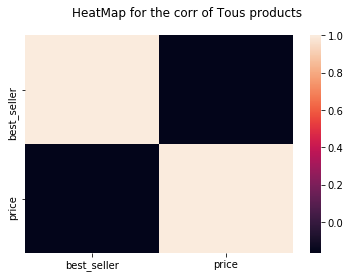

In [18]:
# plt.figure(figsize=(16,8))
sns.heatmap(data.corr())
plt.suptitle('HeatMap for the corr of Tous products');

Distribution of data across the price:

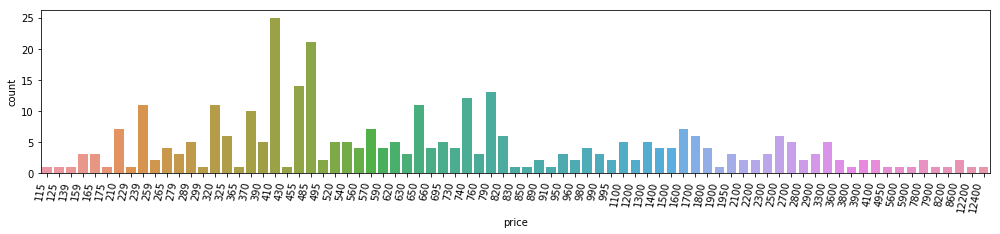

In [17]:
plt.figure(figsize=(17,3))
ax = sns.countplot(x="price", data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80, ha="right")
plt.show()

Distribution of data across the best_selling categories:

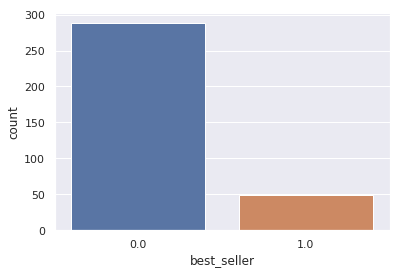

In [83]:
sns.set(style="darkgrid")
sns.countplot(x="best_seller", data=data)
plt.show()

## Retrieving images from links

The task of this section is to download images from their links that are in the 'image' column. We will loop over all links and store its coresspondant image to two folders: best selling folder and not best selling folder. We weill using urlib methods for downlading images. First we have to clean the image links from characters that are not part of the url link. Finally, each image is stored with its index as name, and then the path is also stored in the new column 'image_path'.

In [19]:
import urllib.request

for index, row in data.iterrows():
    img_link = row['image'].replace("['", "").replace("']", "")
    img_path = "{:03d}".format(index) + ".jpg"
    #keras image preprocessing lib takes each foldor as a class label, thus we need to put them in different classes
    if row['best_seller'] == 1:
        print(index, "./images/best_selling/"+img_path, img_link)
        urllib.request.urlretrieve(img_link, "./images/best_selling/"+img_path)
        data.at[index, "image_path"] = "./images/best_selling/"+img_path
    else:
        print(index, "./images/not_best_selling/"+img_path, img_link)
        urllib.request.urlretrieve(img_link, "./images/not_best_selling/"+img_path)
        data.at[index, "image_path"] = "./images/not_best_selling/"+img_path

0 ./images/best_selling/000.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/2/1/211140420.jpg
1 ./images/best_selling/001.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/4/1/411143500.jpg
2 ./images/best_selling/002.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/2/1/214833500.jpg
3 ./images/best_selling/003.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/4/1/415900174.jpg
4 ./images/best_selling/004.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/5/1/511000795.jpg
5 ./images/best_selling/005.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/3/1/311003200.jpg
6 ./images/best_selling/006.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136

56 ./images/not_best_selling/056.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/9/1/915301620.jpg
57 ./images/not_best_selling/057.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/9/1/915301610.jpg
58 ./images/not_best_selling/058.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/9/1/915301590.jpg
59 ./images/not_best_selling/059.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/9/1/915301580.jpg
60 ./images/not_best_selling/060.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/9/1/915301570.jpg
61 ./images/not_best_selling/061.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/9/1/915301560.jpg
62 ./images/not_best_selling/062.jpg https://cdn.tous.com/media/catalog/product/cache/image/51

111 ./images/not_best_selling/111.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/C/8/C812465530.jpg
112 ./images/not_best_selling/112.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/C/8/C812465510.jpg
113 ./images/not_best_selling/113.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/C/8/C812465500.jpg
114 ./images/not_best_selling/114.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/C/8/C812465000.jpg
115 ./images/not_best_selling/115.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/C/8/C812455580.jpg
116 ./images/not_best_selling/116.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/C/8/C812455550.jpg
117 ./images/not_best_selling/117.jpg https://cdn.tous.com/media/catalog/product/c

165 ./images/not_best_selling/165.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/9/1/918453570.jpg
166 ./images/not_best_selling/166.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/9/1/918573580.jpg
167 ./images/not_best_selling/167.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/9/1/918563500.jpg
168 ./images/not_best_selling/168.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/9/1/918573510.jpg
169 ./images/not_best_selling/169.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/8/1/812453610.jpg
170 ./images/not_best_selling/170.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/8/1/812453590.jpg
171 ./images/not_best_selling/171.jpg https://cdn.tous.com/media/catalog/product/cache/i

219 ./images/not_best_selling/219.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/8/1/818022570.jpg
220 ./images/not_best_selling/220.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/8/1/818022540.jpg
221 ./images/not_best_selling/221.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/8/1/815032500.jpg
222 ./images/not_best_selling/222.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/8/1/812442030.jpg
223 ./images/not_best_selling/223.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/8/1/812442160.jpg
224 ./images/not_best_selling/224.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/8/1/812442020.jpg
225 ./images/not_best_selling/225.jpg https://cdn.tous.com/media/catalog/product/cache/i

273 ./images/not_best_selling/273.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/8/1/812314550.jpg
274 ./images/not_best_selling/274.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/8/1/812314570.jpg
275 ./images/not_best_selling/275.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/8/1/812314540.jpg
276 ./images/not_best_selling/276.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/8/1/812314520.jpg
277 ./images/not_best_selling/277.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/8/1/812314510.jpg
278 ./images/not_best_selling/278.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/8/1/812314530.jpg
279 ./images/not_best_selling/279.jpg https://cdn.tous.com/media/catalog/product/cache/i

327 ./images/not_best_selling/327.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/3/1/311902520.jpg
328 ./images/not_best_selling/328.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/3/1/311901280.jpg
329 ./images/not_best_selling/329.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/2/1/218500440.jpg
330 ./images/not_best_selling/330.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/2/1/217092600.jpg
331 ./images/not_best_selling/331.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/2/1/216352540.jpg
332 ./images/not_best_selling/332.jpg https://cdn.tous.com/media/catalog/product/cache/image/512x512/9df78eab33525d08d6e5fb8d27136e95/2/1/214002050.jpg
333 ./images/not_best_selling/333.jpg https://cdn.tous.com/media/catalog/product/cache/i

Our dataframe will lool like this now:

In [20]:
data.head()

,best_seller,price,image,image_path
0,1.0,485,['https://cdn.tous.com/media/catalog/product/c...,./images/best_selling/000.jpg
1,1.0,620,['https://cdn.tous.com/media/catalog/product/c...,./images/best_selling/001.jpg
2,1.0,370,['https://cdn.tous.com/media/catalog/product/c...,./images/best_selling/002.jpg
3,1.0,370,['https://cdn.tous.com/media/catalog/product/c...,./images/best_selling/003.jpg
4,1.0,1300,['https://cdn.tous.com/media/catalog/product/c...,./images/best_selling/004.jpg


Lets explore some randome images from our dataser. We will pick two random images from each class.

best sell class:

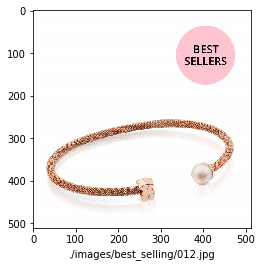

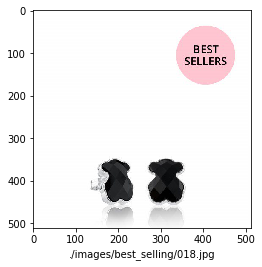

In [37]:
import random

img_path = "./images/best_selling/"+"{:03d}".format(random.randrange(50)) + ".jpg"
img = plt.imread(img_path)
plt.imshow(img)
plt.xlabel(img_path)
plt.show()

img_path = "./images/best_selling/"+"{:03d}".format(random.randrange(50)) + ".jpg"
img = plt.imread(img_path)
plt.imshow(img)
plt.xlabel(img_path)
plt.show()

Not best-selling class:

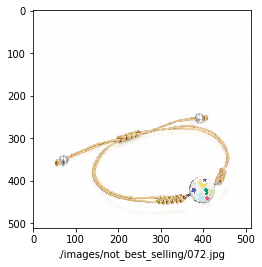

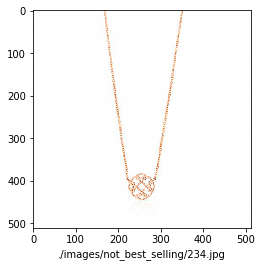

In [39]:
import random

img_path = "./images/not_best_selling/"+"{:03d}".format(random.randrange(49, 337)) + ".jpg"
img = plt.imread(img_path)
plt.imshow(img)
plt.xlabel(img_path)
plt.show()

img_path = "./images/not_best_selling/"+"{:03d}".format(random.randrange(49, 337)) + ".jpg"
img = plt.imread(img_path)
plt.imshow(img)
plt.xlabel(img_path)
plt.show()

### Summary

We notice that the best-selling images have a sticker. Since we are doing CNN on these images, the model will identify this sticker as a pattern for best-selling images. This will results in a model with high variance, which we don't want. The task of the next section is to remove this sticker/tag from all images.

## OpenCv image preprocessing

We have to remove the 'best seller' tag from the best-selling products, since it will affect our trainging. We use OpencCV for this task. The main mehtod used is template matching. 

We are going to imolement a modified Template Matching approach. Here's the overall strategy:

- Load template, convert to grayscale, perform canny edge detection
- Load original image, convert to grayscale
- Continuously rescale image, apply template matching using edges, and keep track of the correlation coefficient (higher value means better match)
- Find coordinates of best fit bounding box then erase unwanted ROI

Much credits of this section go to @nathancy from Stackoverflow.com for his help.

Resources:

- https://docs.opencv.org/trunk/d4/dc6/tutorial_py_template_matching.html
- https://docs.opencv.org/3.4/dd/d4d/tutorial_js_image_arithmetics.html
- https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
- https://docs.opencv.org/master/df/d3d/tutorial_py_inpainting.html#gsc.tab=0

Here's an example of an image with tag and the tag that we want to remove.

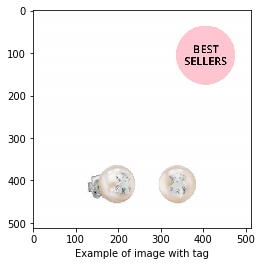

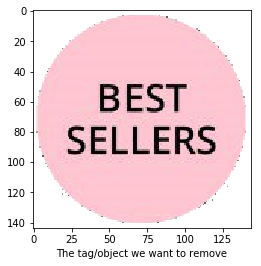

In [43]:
import numpy as np
import cv2 as cv

img = plt.imread('./images/001.jpg')
plt.xlabel('Example of image with tag')
plt.imshow(img)
plt.show()


sticker = plt.imread('./images/tag.png')
plt.xlabel('The tag/object we want to remove')
plt.imshow(sticker)
plt.show()

### Visual demo of Template Matching

Visual demo of the modified Template Matching approach.

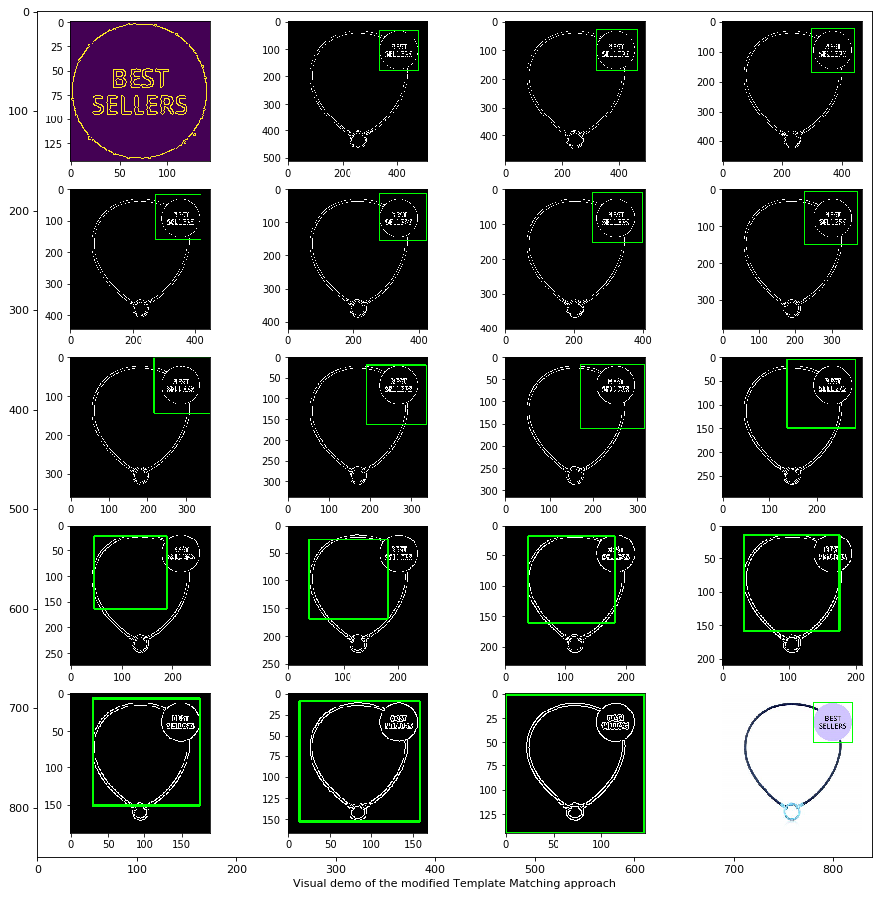

In [186]:
from matplotlib.pyplot import figure

img = plt.imread('./images/resize_detect_object.png')
figure(num=None, figsize=(16, 14), dpi=80, facecolor='w', edgecolor='k')

plt.xlabel('Visual demo of the modified Template Matching approach')
plt.imshow(img)
plt.show()


### Define the resize method
used to rescale the image

In [95]:
import cv2
import numpy as np

# Resizes a image and maintains aspect ratio
def maintain_aspect_ratio_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # Grab the image size and initialize dimensions
    dim = None
    (h, w) = image.shape[:2]

    # Return original image if no need to resize
    if width is None and height is None:
        return image

    # We are resizing height if width is none
    if width is None:
        # Calculate the ratio of the height and construct the dimensions
        r = height / float(h)
        dim = (int(w * r), height)
    # We are resizing width if height is none
    else:
        # Calculate the ratio of the 0idth and construct the dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # Return the resized image
    return cv2.resize(image, dim, interpolation=inter)

### Define the remove_tag method
used for loading imag, loading tag, call the resize method, and remove tag

In [108]:
def remove_tag(imag_path):
    # Load template, convert to grayscale, perform canny edge detection
    template = cv2.imread('./images/tag.png')
    template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    template = cv2.Canny(template, 50, 200)
    (tH, tW) = template.shape[:2]


    # Load original image, convert to grayscale
#     original_image = cv2.imread('./images/best_selling (copy)/036.jpg')
    original_image = cv2.imread(imag_path)
    final = original_image.copy()
    gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    found = None

    # Dynamically rescale image for better template matching
    for scale in np.linspace(0.2, 1.0, 20)[::-1]:

        # Resize image to scale and keep track of ratio
        resized = maintain_aspect_ratio_resize(gray, width=int(gray.shape[1] * scale))
        r = gray.shape[1] / float(resized.shape[1])

        # Stop if template image size is larger than resized image
        if resized.shape[0] < tH or resized.shape[1] < tW:
            break

        # Detect edges in resized image and apply template matching
        canny = cv2.Canny(resized, 50, 200)
        detected = cv2.matchTemplate(canny, template, cv2.TM_CCOEFF)
        (_, max_val, _, max_loc) = cv2.minMaxLoc(detected)

        # Keep track of correlation value
        # Higher correlation means better match
        if found is None or max_val > found[0]:
            found = (max_val, max_loc, r)

    # Compute coordinates of bounding box
    (_, max_loc, r) = found
    (start_x, start_y) = (int(max_loc[0] * r), int(max_loc[1] * r))
    (end_x, end_y) = (int((max_loc[0] + tW) * r), int((max_loc[1] + tH) * r))

    # Draw bounding box on ROI to remove
    cv2.rectangle(original_image, (start_x, start_y), (end_x, end_y), (0,255,0), 2)
    # cv2.circle(original_image,(end_x, end_y),125, (0,255,0), 2)

    # Erase unwanted ROI (Fill ROI with white)
    cv2.rectangle(final, (start_x, start_y), (end_x, end_y), (255,255,255), -1)
    # cv2.circle(original_image,(end_x, end_y),15, (255,255,255), -1)

#     plt.imshow(final)
#     plt.show()
    cv2.imwrite(imag_path,final)
    # cv2.waitKey(0)

### Remove tags from images

Iterate over the images and call the remove_tag mehtod

In [109]:
for i in range(50):
    img_path = "./images/best_selling/"+"{:03d}".format(i) + ".jpg"
    remove_tag(img_path)

Plotting random images after removing the tage:

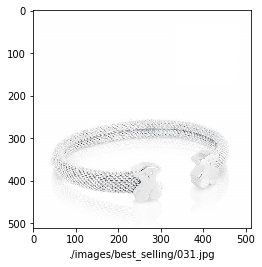

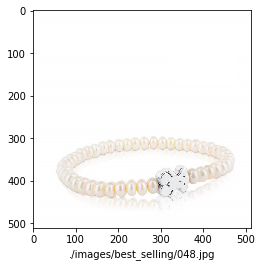

In [110]:
import random

img_path = "./images/best_selling/"+"{:03d}".format(random.randrange(50)) + ".jpg"
img = plt.imread(img_path)
plt.imshow(img)
plt.xlabel(img_path)
plt.show()

img_path = "./images/best_selling/"+"{:03d}".format(random.randrange(50)) + ".jpg"
img = plt.imread(img_path)
plt.imshow(img)
plt.xlabel(img_path)
plt.show()

### Summary

We succeded at removing all tags from the best-selling images. In the next section we continue doing image processing but with Keras image processing libraries. The next step is more focused on how we should feed the images to the model.

## CNN image classifier

We will build a model that classifies images whether they are of best-selling products or not. We first perform some Keras preprocessing on the images, like scaling and validation split. Secondly, we build a simole CNN classifier using the configurations given by the documentation. Thirdly, we carry one empirical experiments, knowen as sequential experiments, to optimize our model. We finally pick the model of the mos optimized experiment and plot the loss function of all experiments.

### Keras image preprocessnig

Resources for this section and the following sections:
- https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
- https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
- https://keras.io/preprocessing/image/#flow_from_dataframe

In [115]:
#Import from keras_preprocessing not from keras.preprocessing

from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np


datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

Using TensorFlow backend.


In [117]:
#the datagem.flow_from_dataframe method deals with categories as string
data['best_seller'] = data['best_seller'].astype(str)

In [119]:
data.head()

,best_seller,price,image,image_path
0,1.0,485,['https://cdn.tous.com/media/catalog/product/c...,./images/best_selling/000.jpg
1,1.0,620,['https://cdn.tous.com/media/catalog/product/c...,./images/best_selling/001.jpg
2,1.0,370,['https://cdn.tous.com/media/catalog/product/c...,./images/best_selling/002.jpg
3,1.0,370,['https://cdn.tous.com/media/catalog/product/c...,./images/best_selling/003.jpg
4,1.0,1300,['https://cdn.tous.com/media/catalog/product/c...,./images/best_selling/004.jpg


In [132]:


train_generator=datagen.flow_from_dataframe(
dataframe=data,
directory="",
x_col="image_path",
y_col="best_seller",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

valid_generator=datagen.flow_from_dataframe(
dataframe=data,
directory="",
x_col="image_path",
y_col="best_seller",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

Found 253 validated image filenames belonging to 2 classes.
Found 84 validated image filenames belonging to 2 classes.


### CNN classification model

In this section we build the first CNN classifcation model usning the deafualt configurations given by Keras tutorials. Later we optimize our model using sequential experiments methodology.

In [133]:
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

In [134]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_17 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 64)        18496     
__________

In [135]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
result = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

Epoch 1/10
7/7 [==============================] - 3s 392ms/step - loss: 0.1485 - acc: 0.9241 - val_loss: 2.0470 - val_acc: 0.3750
Epoch 2/10
7/7 [==============================] - 1s 120ms/step - loss: 0.0046 - acc: 1.0000 - val_loss: 2.2962 - val_acc: 0.4423
Epoch 3/10
7/7 [==============================] - 2s 273ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 2.7219 - val_acc: 0.4423
Epoch 4/10
7/7 [==============================] - 2s 233ms/step - loss: 5.4139e-04 - acc: 1.0000 - val_loss: 3.1787 - val_acc: 0.4062
Epoch 5/10
7/7 [==============================] - 3s 426ms/step - loss: 2.9671e-04 - acc: 1.0000 - val_loss: 3.2441 - val_acc: 0.4423
Epoch 6/10
7/7 [==============================] - 3s 456ms/step - loss: 1.7683e-04 - acc: 1.0000 - val_loss: 3.7646 - val_acc: 0.4038
Epoch 7/10
7/7 [==============================] - 2s 317ms/step - loss: 8.3059e-05 - acc: 1.0000 - val_loss: 3.7784 - val_acc: 0.4375
Epoch 8/10
7/7 [==============================] - 2s 258ms/step - loss: 5.

We will resample the validation set and evaluate our model based on it. 

In [137]:
model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID)

[4.764006614685059, 0.390625]

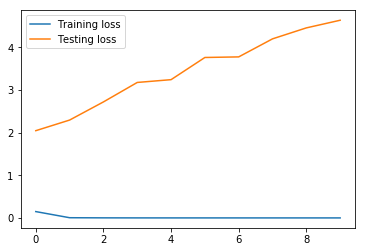

In [138]:
## plot loss function
test_loss = result.history['val_loss']
train_loss = result.history['loss']

plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

##### Results of CNN best-selling class
The resulted loss func is 4.7, and the accuracy is 0.39. This medicore results could be advanced with larger data or emprically trying different hyperparameters. Also, loss function for the validation set keeps increasing leanearly. 

#### CNN classifier model with early stopping

Here we try to maximize the validation accuracy by increasing the number of times the model runs, epoch, wile implementing an early stop. We will use the same model's layers.

In [140]:
# Import EarlyStopping
from keras.callbacks import EarlyStopping

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)


results_early_stop = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    callbacks=[early_stopping_monitor]
)

Epoch 1/10
7/7 [==============================] - 2s 317ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 9.9188 - val_acc: 0.3846
Epoch 2/10
7/7 [==============================] - 2s 322ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 9.2989 - val_acc: 0.4231
Epoch 3/10
7/7 [==============================] - 2s 341ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 4/10
7/7 [==============================] - 2s 279ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 8.3690 - val_acc: 0.4808
Epoch 5/10
7/7 [==============================] - 2s 298ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 9.6089 - val_acc: 0.4038
Epoch 6/10
7/7 [==============================] - 2s 324ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 9.3183 - val_acc: 0.4219


Let's evaluate our model performance and plot the loss function:

In [141]:
model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID)

[9.821964740753174, 0.390625]

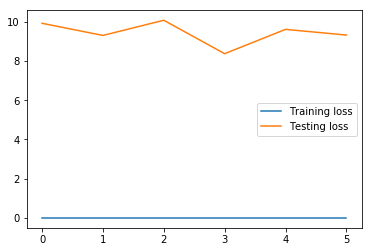

In [142]:
## plot loss function
test_loss = results_early_stop.history['val_loss']
train_loss = results_early_stop.history['loss']

plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

##### Results of CNN classifier with early stop

The resulted loss func is 9.8, and the accuracy is 0.39. The model run less times than without implementing early stop. There's no significat improvement in the accuracy.

### Sequential experiments optimization

The aim is to use Sequential expreiments approach to optimize CNN classifier model

Tunning hyperparameters of CNN models is an empirical process. Here we carry on multiple experiements to arrive to the optimal hyperparameters. We use the accuracy meteric to compare our results.

#### 1st experiment

In [149]:
#1st experiment

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

results_exper_1 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=500,
                    callbacks=[early_stopping_monitor],
                    verbose=False                                   
)

model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID)

[6.343092203140259, 0.375]

We will increase capacity in second experiment by incrasing number of nodes to 64 at the same layer.

#### 2nd experiment

In [150]:
#2nd experiment

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

results_exper_2 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=500,
                    callbacks=[early_stopping_monitor],
                    verbose=False                                   
)

model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID)

[8.361176160665659, 0.4038461492611812]

Since the accuracy has increased in the 2nd experiement, we will keep the number of nodes unchanged and we will increase capacity through adding one more layer of 64 nodes.

#### 3rd experiment

In [152]:
### 3rd experiment

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

results_exper_3 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=500,
                    callbacks=[early_stopping_monitor],
                    verbose=False                                   
)

model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID)

[6.287987929124099, 0.4038461515536675]

Accuracy has not changed. We increase capacity through adding an extra layer.

#### 4th experiment

In [155]:
### 4th experiment

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

results_exper_4 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=500,
                    callbacks=[early_stopping_monitor],
                    verbose=False                                   
)

model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID)

[3.0577508302835317, 0.38461538003041196]

The accurace of experiment 4 decreased, so we will revoke this step and we we will increase capacity through adding more nodes than previouse.

#### 5th experiment

In [156]:
### 5th experiment

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

results_exper_5 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=500,
                    callbacks=[early_stopping_monitor],
                    verbose=False                                   
)

model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID)

[3.1784549951553345, 0.46875]

The accuracy increases, we are in the right way. Let's add more nodes to the same layer.

#### 6th experiment


In [157]:
### 5th experiment

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(264, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

results_exper_6 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=500,
                    callbacks=[early_stopping_monitor],
                    verbose=False                                   
)

model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID)

[3.5343935673053446, 0.42307692078443676]

Accuracy decreases. Revoke this step and add extra layer of the same number of nodes, 128.

#### 7th experiment

In [158]:
### 5th experiment

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

results_exper_7 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=500,
                    callbacks=[early_stopping_monitor],
                    verbose=False                                   
)

model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID)

[3.4715550312629113, 0.4423076923076923]

#### Conclusion 
Accuracy still less than of experiment 5; we revoke this step and we decide on the model of experiment 5 to be the optimal.

#### Summary table of sequenatial experiments

| Hidden Layers | Nodes Per Layer | Accuracy | Next Step                    |
|---------------|-----------------|----------|------------------------------|
| 1             | 32              | 0.37     | Increase Capacity            |
| 1             | 64              | 0.4      | Increase Capacity            |
| 2             | 64              | 0.4      | Increase Capacity            |
| 3             | 64              | 0.38     | Revoke and increase capacity |
| 3             | 128             | 0.46     | Increase Capacity            |
| 3             | 264             | 0.42     | Revoke and increase capacity |
| 4             | 128             | 0.44     | Done                         |

#### Plot loss function of differnt experiments

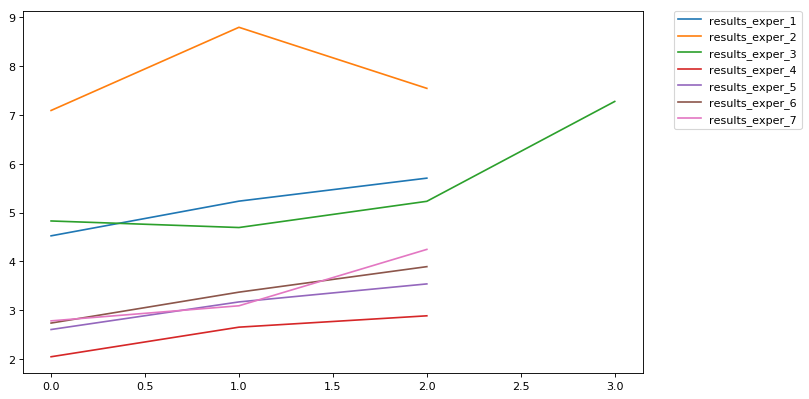

In [172]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(results_exper_1.history['val_loss'], label="results_exper_1")
plt.plot(results_exper_2.history['val_loss'], label="results_exper_2")
plt.plot(results_exper_3.history['val_loss'], label="results_exper_3")
plt.plot(results_exper_4.history['val_loss'], label="results_exper_4")
plt.plot(results_exper_5.history['val_loss'], label="results_exper_5")
plt.plot(results_exper_6.history['val_loss'], label="results_exper_6")
plt.plot(results_exper_7.history['val_loss'], label="results_exper_7")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()


### Exporting CNN classifier model

The best model is of experiemnt 5, we will run it again and then save it.

In [176]:
### 5th experiment
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

results_exper_5 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=500,
                    callbacks=[early_stopping_monitor],
                    verbose=False                                   
)

model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID)

[3.6767412699185886, 0.4423076923076923]

In [180]:
from keras.models import load_model
model.save('CNN_classifier_bestselling.h5')

## CNN image regression (Extra)

We will build a CNN regression model to predict prices of each product based on it image. We first do the required Keras preprocessing to feed the model, and then we configure two models. This section has been added for experimental purposes. No optimization has been carried on.

### Keras image preprocessnig

Resources for this section:
- https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1

In [161]:
data_cnn.dtypes

best_seller     object
price          float64
image_path      object
dtype: object

In [125]:


train_generator=datagen.flow_from_dataframe(
dataframe=data,
directory="",
x_col="image_path",
y_col="price",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="other", #other type since it's regression
target_size=(32,32))

valid_generator=datagen.flow_from_dataframe(
dataframe=data,
directory="",
x_col="image_path",
y_col="price",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="other", #other type since it's regression
target_size=(32,32))

Found 253 validated image filenames.
Found 84 validated image filenames.


### CNN regression model

In [126]:
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# model.add(Dense(2, activation='softmax'))
model.add(Dense(1)) #the last hidden layer, it's only one
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [165]:
#implementing metrics for the CNN regression
from keras import backend
 
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [166]:
# model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])

In [168]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

results = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

Epoch 1/10
7/7 [==============================] - 2s 338ms/step - loss: 90180.9571 - rmse: 255.2051 - val_loss: 90598.5156 - val_rmse: 241.6827
Epoch 2/10
7/7 [==============================] - 4s 551ms/step - loss: 88544.2592 - rmse: 256.0247 - val_loss: 110294.2067 - val_rmse: 258.1575
Epoch 3/10
7/7 [==============================] - 2s 286ms/step - loss: 85601.1265 - rmse: 255.0347 - val_loss: 115000.9940 - val_rmse: 271.2849
Epoch 4/10
7/7 [==============================] - 2s 301ms/step - loss: 88694.3818 - rmse: 252.9188 - val_loss: 87134.5820 - val_rmse: 222.7198
Epoch 5/10
7/7 [==============================] - 3s 469ms/step - loss: 88914.9965 - rmse: 256.4169 - val_loss: 113182.4712 - val_rmse: 278.5800
Epoch 6/10
7/7 [==============================] - 4s 500ms/step - loss: 91068.3022 - rmse: 261.9643 - val_loss: 91681.4243 - val_rmse: 237.4661
Epoch 7/10
7/7 [==============================] - 2s 355ms/step - loss: 87825.1166 - rmse: 254.5939 - val_loss: 93101.6602 - val_rmse

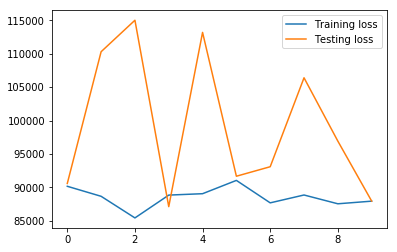

In [169]:
## plot loss function
test_loss = results.history['val_loss']
train_loss = results.history['loss']

plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()


We can see that the results are not good enough, so now we are going to increase the epoch value and see how the model performs. The picked values of hyperparameters are chosed randomly; arriving to the best hyperparameters is an emprical process!

In [170]:
results_2 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=500)

Epoch 1/500
7/7 [==============================] - 2s 331ms/step - loss: 88291.0412 - rmse: 254.9990 - val_loss: 68412.6309 - val_rmse: 202.8245
Epoch 2/500
7/7 [==============================] - 2s 332ms/step - loss: 90816.7782 - rmse: 255.7474 - val_loss: 155025.7416 - val_rmse: 321.1970
Epoch 3/500
7/7 [==============================] - 2s 292ms/step - loss: 100321.4881 - rmse: 271.8574 - val_loss: 76970.6806 - val_rmse: 207.8256
Epoch 4/500
7/7 [==============================] - 2s 294ms/step - loss: 88022.7613 - rmse: 252.0680 - val_loss: 117473.4883 - val_rmse: 277.6836
Epoch 5/500
7/7 [==============================] - 3s 454ms/step - loss: 88782.7000 - rmse: 256.3097 - val_loss: 88682.0120 - val_rmse: 224.4193
Epoch 6/500
7/7 [==============================] - 3s 484ms/step - loss: 86742.2064 - rmse: 255.2806 - val_loss: 108474.1538 - val_rmse: 268.4040
Epoch 7/500
7/7 [==============================] - 3s 477ms/step - loss: 88816.4263 - rmse: 257.1012 - val_loss: 108427.6797 -

Epoch 57/500
7/7 [==============================] - 2s 329ms/step - loss: 85025.0813 - rmse: 248.4658 - val_loss: 97814.2079 - val_rmse: 243.0663
Epoch 58/500
7/7 [==============================] - 2s 329ms/step - loss: 92726.8608 - rmse: 260.9100 - val_loss: 103913.0977 - val_rmse: 263.2867
Epoch 59/500
7/7 [==============================] - 2s 324ms/step - loss: 78049.8303 - rmse: 237.1547 - val_loss: 125325.6466 - val_rmse: 288.8563
Epoch 60/500
7/7 [==============================] - 2s 333ms/step - loss: 83364.3445 - rmse: 247.0928 - val_loss: 102575.4387 - val_rmse: 262.0108
Epoch 61/500
7/7 [==============================] - 3s 406ms/step - loss: 88753.4611 - rmse: 255.7525 - val_loss: 99543.1367 - val_rmse: 260.3408
Epoch 62/500
7/7 [==============================] - 2s 333ms/step - loss: 85001.4092 - rmse: 247.7205 - val_loss: 82291.2542 - val_rmse: 227.1792
Epoch 63/500
7/7 [==============================] - 2s 352ms/step - loss: 88255.5893 - rmse: 254.8967 - val_loss: 107567.

Epoch 113/500
7/7 [==============================] - 2s 322ms/step - loss: 81635.1029 - rmse: 246.5559 - val_loss: 136308.7578 - val_rmse: 296.6431
Epoch 114/500
7/7 [==============================] - 2s 307ms/step - loss: 76733.4066 - rmse: 228.1336 - val_loss: 106001.4087 - val_rmse: 245.1857
Epoch 115/500
7/7 [==============================] - 3s 386ms/step - loss: 72913.3361 - rmse: 222.6858 - val_loss: 147799.4297 - val_rmse: 316.7296
Epoch 116/500
7/7 [==============================] - 3s 447ms/step - loss: 86776.2248 - rmse: 252.5891 - val_loss: 110411.4050 - val_rmse: 246.9128
Epoch 117/500
7/7 [==============================] - 4s 523ms/step - loss: 83507.5076 - rmse: 240.5637 - val_loss: 186916.8125 - val_rmse: 360.9114
Epoch 118/500
7/7 [==============================] - 3s 461ms/step - loss: 82550.6322 - rmse: 241.8846 - val_loss: 102279.3906 - val_rmse: 244.3746
Epoch 119/500
7/7 [==============================] - 3s 407ms/step - loss: 86828.4855 - rmse: 250.9588 - val_los

7/7 [==============================] - 3s 375ms/step - loss: 31488.0273 - rmse: 139.9259 - val_loss: 196458.9688 - val_rmse: 356.3300
Epoch 224/500
7/7 [==============================] - 3s 372ms/step - loss: 28285.3317 - rmse: 133.3068 - val_loss: 184919.3462 - val_rmse: 359.2304
Epoch 225/500
7/7 [==============================] - 3s 375ms/step - loss: 33266.9409 - rmse: 139.6040 - val_loss: 155368.0769 - val_rmse: 307.8599
Epoch 226/500
7/7 [==============================] - 2s 330ms/step - loss: 28902.7831 - rmse: 134.6438 - val_loss: 156921.8438 - val_rmse: 313.6660
Epoch 227/500
7/7 [==============================] - 2s 316ms/step - loss: 28817.0469 - rmse: 135.1696 - val_loss: 215502.9904 - val_rmse: 381.2114
Epoch 228/500
7/7 [==============================] - 2s 327ms/step - loss: 31137.7397 - rmse: 138.1687 - val_loss: 177587.4050 - val_rmse: 328.8945
Epoch 229/500
7/7 [==============================] - 2s 356ms/step - loss: 29918.0339 - rmse: 137.4115 - val_loss: 234565.2969

Epoch 334/500
7/7 [==============================] - 3s 366ms/step - loss: 11932.6794 - rmse: 84.1484 - val_loss: 193287.5156 - val_rmse: 362.6814
Epoch 335/500
7/7 [==============================] - 2s 352ms/step - loss: 13505.1068 - rmse: 83.4590 - val_loss: 229675.9928 - val_rmse: 383.1266
Epoch 336/500
7/7 [==============================] - 3s 384ms/step - loss: 12801.2946 - rmse: 89.3904 - val_loss: 154725.0373 - val_rmse: 315.2130
Epoch 337/500
7/7 [==============================] - 2s 351ms/step - loss: 14811.2353 - rmse: 94.2439 - val_loss: 192220.9219 - val_rmse: 349.3060
Epoch 338/500
7/7 [==============================] - 2s 301ms/step - loss: 12429.2189 - rmse: 85.1888 - val_loss: 217267.1587 - val_rmse: 381.9220
Epoch 339/500
7/7 [==============================] - 2s 349ms/step - loss: 11725.3668 - rmse: 80.3249 - val_loss: 164489.7716 - val_rmse: 320.8774
Epoch 340/500
7/7 [==============================] - 2s 321ms/step - loss: 11347.5665 - rmse: 85.0792 - val_loss: 1790

Epoch 390/500
7/7 [==============================] - 2s 322ms/step - loss: 9295.0884 - rmse: 75.8247 - val_loss: 222316.0300 - val_rmse: 374.8448
Epoch 391/500
7/7 [==============================] - 2s 330ms/step - loss: 8523.1118 - rmse: 70.1647 - val_loss: 195781.1797 - val_rmse: 359.3745
Epoch 392/500
7/7 [==============================] - 2s 330ms/step - loss: 9118.0911 - rmse: 72.7650 - val_loss: 176744.3966 - val_rmse: 344.5814
Epoch 393/500
7/7 [==============================] - 2s 340ms/step - loss: 9398.9960 - rmse: 74.2020 - val_loss: 212164.0793 - val_rmse: 362.2757
Epoch 394/500
7/7 [==============================] - 2s 346ms/step - loss: 8944.5176 - rmse: 70.6491 - val_loss: 205329.4219 - val_rmse: 366.0129
Epoch 395/500
7/7 [==============================] - 3s 360ms/step - loss: 12418.2652 - rmse: 87.4024 - val_loss: 166917.5457 - val_rmse: 326.2102
Epoch 396/500
7/7 [==============================] - 2s 332ms/step - loss: 11070.3175 - rmse: 80.3824 - val_loss: 212564.51

Epoch 446/500
7/7 [==============================] - 2s 312ms/step - loss: 9621.6664 - rmse: 71.1849 - val_loss: 184311.9880 - val_rmse: 329.4798
Epoch 447/500
7/7 [==============================] - 2s 335ms/step - loss: 8378.5539 - rmse: 68.1648 - val_loss: 181129.7981 - val_rmse: 350.8078
Epoch 448/500
7/7 [==============================] - 2s 356ms/step - loss: 7215.1691 - rmse: 63.0352 - val_loss: 175679.1406 - val_rmse: 335.6948
Epoch 449/500
7/7 [==============================] - 2s 316ms/step - loss: 7377.6374 - rmse: 66.0428 - val_loss: 160369.7380 - val_rmse: 310.4855
Epoch 450/500
7/7 [==============================] - 2s 341ms/step - loss: 8970.3904 - rmse: 68.3970 - val_loss: 227711.3221 - val_rmse: 386.4961
Epoch 451/500
7/7 [==============================] - 2s 330ms/step - loss: 6717.7273 - rmse: 62.1592 - val_loss: 172655.1953 - val_rmse: 329.0453
Epoch 452/500
7/7 [==============================] - 2s 351ms/step - loss: 10008.0943 - rmse: 73.6540 - val_loss: 207831.790

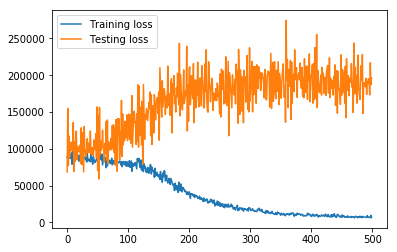

In [172]:
## plot loss function for the second trial
test_loss = results_2.history['val_loss']
train_loss = results_2.history['loss']

plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

##### Results of the CNN regression

The plot shows poor results of CNN regression model, as the test loss fun deviates from the training loss fun. However, an early stop could be implemented since the loss fun doesn't get better at some points. With some emprical trials on the CNN hyperparametrs, we might arrive at better results. We leave that for future tunning!